In [3]:
from __future__ import division, print_function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

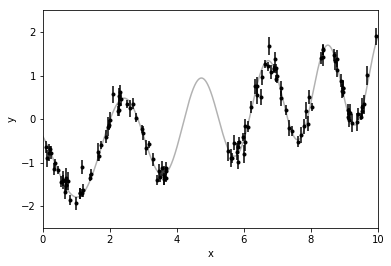

In [2]:
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [3]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [4]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -6.756596382629468


In [5]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -0.84977866562586946), ('kernel:terms[0]:log_omega0', 1.0986122886681098), ('kernel:terms[1]:log_S0', -1.1963522559058422), ('kernel:terms[1]:log_Q', 0.0), ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')

parameter_vector:
[-0.84977867  1.09861229 -1.19635226  0.          1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 15), (-15, 15)]



In [6]:
print(gp.get_parameter_names())
gp.freeze_parameter("kernel:terms[0]:log_omega0")
print(gp.get_parameter_names())
gp.thaw_parameter("kernel:terms[0]:log_omega0")
print(gp.get_parameter_names())

('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')
('kernel:terms[0]:log_S0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')


In [7]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -16.563201709335942
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.70530257e-05,   1.42108547e-05,   5.68434189e-06,
         5.68434189e-06,   2.84217094e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 252
      nit: 30
   status: 0
  success: True
        x: array([ 3.27772777, -2.02443035, -4.16135078,  2.34184241,  1.13554507])


In [8]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

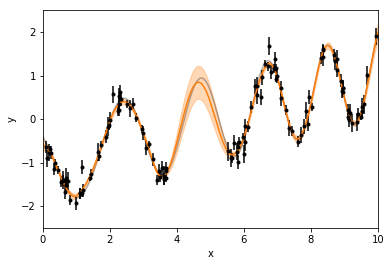

In [9]:
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

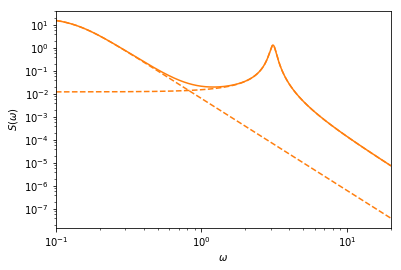

In [10]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");